# DTW applied to test dataset
In this notebook we are going to test how Dynamic Time Wrapping (DTW) performs in the test dataset.

## 1. Load data

In [57]:
import pickle
with open(f"../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
meta_obs = data['meta']
data_obs = data['data']
print(len(meta_obs), len(data_obs))

1188 1188


## 2. Calculate DTW distance - complete series
`dtw` does not look at time nor sampling rate, it asumes that the values are equally spread in the two time-series. This is going to be tricky to account for when comparing different time-series.
Also the distance given by `dtw` is not normalized, it would be still needed ot normalize by the path distances as:
```python
from tslearn.metrics import dtw_path

path, dist = dtw_path(x, y)
normalized_dist = dist / len(path)
```

In [91]:
import numpy as np
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt

In [ ]:
distance_bro_dino_pairs, norm_distance_bro_dino_pairs, gld_pairs = [], [], []
# Loop trough the data
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    bro_ts = data_obs[gld]['bro']
    if dino_ts.shape != bro_ts.shape:
        print(f"Shape mismatch for {gld}: dino {dino_ts.shape}, bro {bro_ts.shape}")
    if np.any(np.isnan(dino_ts)): 
        print(f"NaN values found for dino {gld} {dino_ts}")
        continue
    if np.any(np.isnan(bro_ts)): 
        print(f"NaN values found for bro {gld} {bro_ts}")
        continue
    if dino_ts.shape[0] < 2 or bro_ts.shape[0] < 2:
        print(f"Too few data points for {gld}: dino {dino_ts.shape}, bro {bro_ts.shape}")
        continue
    # time-series normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    bro_ts[:, 1] = (bro_ts[:, 1] - np.mean(bro_ts[:, 1])) / np.std(bro_ts[:, 1])
    gld_pairs.append(gld)
    
    # raw DTW distance
    distance_bro_dino_pairs.append(dtw(dino_ts[:, 1], bro_ts[:, 1]))

    # normalized distance
    path, dist = dtw_path(dino_ts[:, 1], bro_ts[:, 1])
    norm_distance_bro_dino_pairs.append(dist / len(path))

In [84]:
len(distance_bro_dino_pairs)

1188

Statistics of DTW distances between bro and dino pairs:
Mean: 0.714690168842173 +- Std: 1.0300351287539204
Median: 0.20510454002894948
Max: 6.679350266300475, Min: 0.0

Statistics of **normalized** DTW distances between bro and dino pairs:
Mean: 0.0020408517652882488 +- Std: 0.0036426575227154123
Median: 0.00047553189912843247
Max: 0.0368168135304774, Min: 0.0


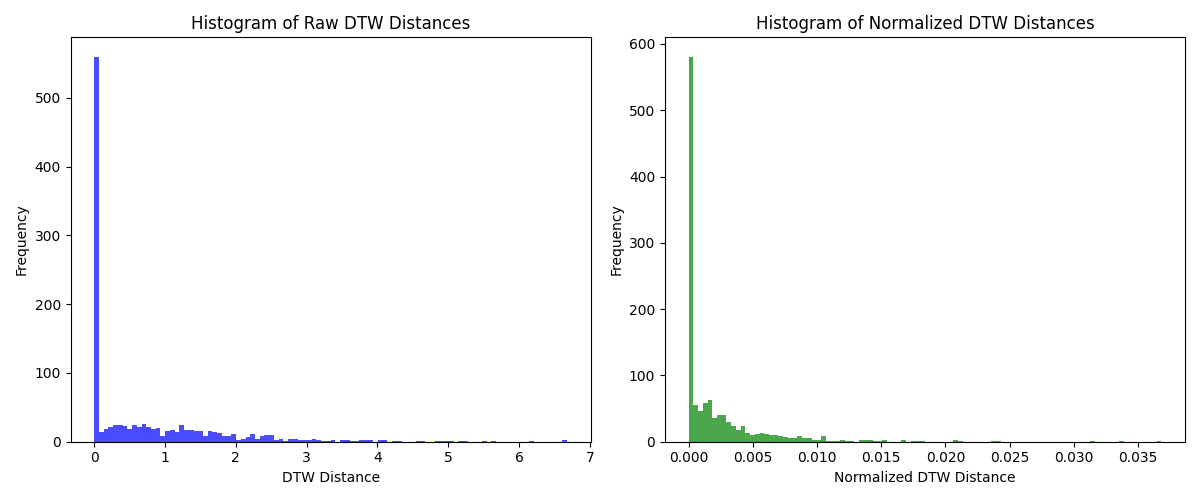

In [96]:
# Statistics
print(f"Statistics of DTW distances between bro and dino pairs:")
print(f"Mean: {np.mean(distance_bro_dino_pairs)} +- Std: {np.std(distance_bro_dino_pairs)}")
print(f"Median: {np.median(distance_bro_dino_pairs)}")
print(f"Max: {np.max(distance_bro_dino_pairs)}, Min: {np.min(distance_bro_dino_pairs)}")

print(f"\nStatistics of **normalized** DTW distances between bro and dino pairs:")
print(f"Mean: {np.mean(norm_distance_bro_dino_pairs)} +- Std: {np.std(norm_distance_bro_dino_pairs)}")
print(f"Median: {np.median(norm_distance_bro_dino_pairs)}")
print(f"Max: {np.max(norm_distance_bro_dino_pairs)}, Min: {np.min(norm_distance_bro_dino_pairs)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Histogram for raw DTW distances
axes[0].hist(distance_bro_dino_pairs, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("DTW Distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of Raw DTW Distances")

# Histogram for normalized DTW distances
axes[1].hist(norm_distance_bro_dino_pairs, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Normalized DTW Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Normalized DTW Distances")

plt.tight_layout()
plt.show()

We expected this distance to be 0 for most (if not all) of the data points, as during the preparation of `test_dataset` we skipped all records having different lengths.

Let's look at the time-series with the maximum distance:

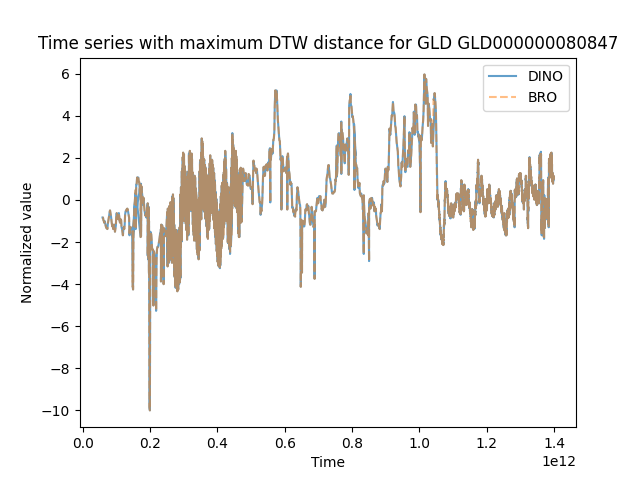

In [ ]:
%matplotlib widget
# get id of the pair with the maximum distance
max_distance_index = np.argmax(distance_bro_dino_pairs)
gld_max_distance = gld_pairs[max_distance_index]
# plot the time series of the pair with the maximum distance
dino_max_DTW = data_obs[gld_max_distance]['dino']
bro_max_DTW = data_obs[gld_max_distance]['bro']
plt.figure()
plt.plot(dino_max_DTW[:, 0], dino_max_DTW[:, 1], label='DINO', alpha=0.7)
plt.plot(bro_max_DTW[:, 0], bro_max_DTW[:, 1], label='BRO', alpha=0.5, linestyle='--')
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.title(f"Time series with maximum DTW distance for {gld_max_distance}")
plt.legend()
plt.show()

There seem to be some non-reproducible errors when storing the data, chracterized by some weird jumps in the dino series. Is rare, but sometimes happens. When querying the data using the same ID, the data looks good, no jumps.

In [97]:
# For reference, calculate distance for a random pair
import random
gld_1 = random.choice(list(data_obs.keys()))
gld_2 = random.choice(list(data_obs.keys()))
dino_ts = data_obs[gld_1]['dino'][:, 1]
bro_ts = data_obs[gld_2]['bro'][:, 1]
dino_ts = (dino_ts - np.mean(dino_ts)) / np.std(dino_ts)
bro_ts = (bro_ts - np.mean(bro_ts)) / np.std(bro_ts)
dtw_random = dtw(dino_ts, bro_ts)
path, dist = dtw_path(dino_ts, bro_ts)
print(f"DTW distance between random pair {gld_1} and {gld_2}: {dtw_random}")
print(f"Normalized DTW distance between random pair {gld_1} and {gld_2}: {dist / len(path)}")

DTW distance between random pair GLD000000109496 and GLD000000060154: 16.92801574205013
Normalized DTW distance between random pair GLD000000109496 and GLD000000060154: 0.009499447666694798


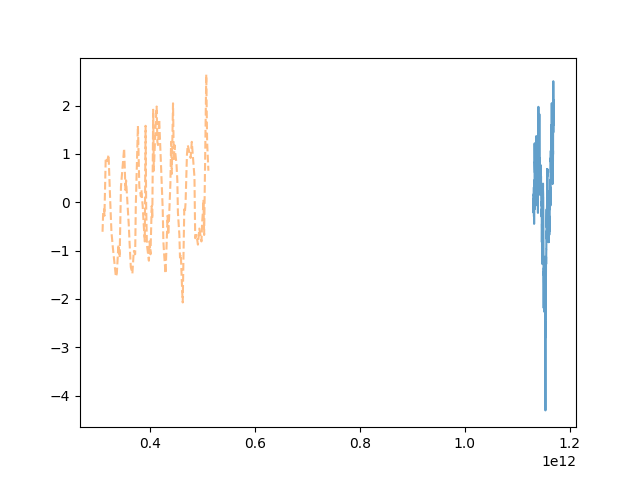

In [98]:
plt.figure()
plt.plot(data_obs[gld_1]['dino'][:, 0], data_obs[gld_1]['dino'][:, 1], label=f'DINO {gld_1}', alpha=0.7)
plt.plot(data_obs[gld_2]['bro'][:, 0], data_obs[gld_2]['bro'][:, 1], label=f'BRO {gld_2}', alpha=0.5, linestyle='--')

## 3. DTW distance - subsequence
`tslearn` also allows to calculate the minimum similarity score between a subsequence and the full time sereis (i.e. template matching). This can be useful to search matches of partial data.